In [1]:
import numpy as np
from PIL import Image
import glob
import os
from tqdm import tqdm

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Pix2pix

all hyperparameters and achitecture taken from original paper: https://arxiv.org/pdf/1611.07004.pdf

In [2]:
dataset_path = "../input/facades/facades/"
NUM_EPOCHS = 300
learning_rate = 2e-4 

def flatten(t):
    return [item for sublist in t for item in sublist]

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"): # transforms_=None,
        self.transform = transforms.Compose(transforms_)
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")
        
            
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)
    
# cancel transforms
transforms_ = [
#     transforms.Resize((286, 286), Image.BICUBIC),
    transforms.ToTensor(),
#     transforms.RandomResizedCrop(size=(256, 256))
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=4,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}",transforms_=transforms_, mode="val"),
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
        

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)
    

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

        
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [4]:
generator = UnetGenerator(3, 3, 64, use_dropout=False)

discriminator = Discriminator(6, 64, n_layers=3)#.cuda().float()

generator.apply(weights_init)
discriminator.apply(weights_init)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [5]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    return gen_total_loss

def discriminator_loss(output, label):
    return adversarial_loss(output, label)

B - inputs, A - target

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: [1/300]: D_loss: 0.609, G_loss: 32.574


  1%|          | 2/300 [00:25<1:00:13, 12.13s/it]

Epoch: [2/300]: D_loss: 0.440, G_loss: 19.895


  1%|          | 3/300 [00:35<54:10, 10.94s/it]  

Epoch: [3/300]: D_loss: 0.356, G_loss: 19.948


  1%|▏         | 4/300 [00:44<50:20, 10.20s/it]

Epoch: [4/300]: D_loss: 0.302, G_loss: 20.144


  2%|▏         | 5/300 [00:53<48:08,  9.79s/it]

Epoch: [5/300]: D_loss: 0.345, G_loss: 19.837


  2%|▏         | 6/300 [01:02<46:46,  9.54s/it]

Epoch: [6/300]: D_loss: 0.358, G_loss: 19.830


  2%|▏         | 7/300 [01:11<45:47,  9.38s/it]

Epoch: [7/300]: D_loss: 0.367, G_loss: 19.408


  3%|▎         | 8/300 [01:20<45:20,  9.32s/it]

Epoch: [8/300]: D_loss: 0.398, G_loss: 19.176


  3%|▎         | 9/300 [01:29<45:11,  9.32s/it]

Epoch: [9/300]: D_loss: 0.416, G_loss: 18.929


  3%|▎         | 10/300 [01:39<44:51,  9.28s/it]

Epoch: [10/300]: D_loss: 0.411, G_loss: 18.583


  4%|▎         | 11/300 [01:48<44:22,  9.21s/it]

Epoch: [11/300]: D_loss: 0.437, G_loss: 17.945


  4%|▍         | 12/300 [01:56<43:43,  9.11s/it]

Epoch: [12/300]: D_loss: 0.440, G_loss: 17.653


  4%|▍         | 13/300 [02:05<43:26,  9.08s/it]

Epoch: [13/300]: D_loss: 0.491, G_loss: 17.127


  5%|▍         | 14/300 [02:15<43:19,  9.09s/it]

Epoch: [14/300]: D_loss: 0.459, G_loss: 16.820


  5%|▌         | 15/300 [02:24<43:32,  9.17s/it]

Epoch: [15/300]: D_loss: 0.490, G_loss: 16.431


  5%|▌         | 16/300 [02:33<43:13,  9.13s/it]

Epoch: [16/300]: D_loss: 0.494, G_loss: 16.003


  6%|▌         | 17/300 [02:42<42:56,  9.10s/it]

Epoch: [17/300]: D_loss: 0.507, G_loss: 15.768


  6%|▌         | 18/300 [02:51<42:42,  9.09s/it]

Epoch: [18/300]: D_loss: 0.521, G_loss: 15.654


  6%|▋         | 19/300 [03:00<42:26,  9.06s/it]

Epoch: [19/300]: D_loss: 0.527, G_loss: 15.093


  7%|▋         | 20/300 [03:09<42:17,  9.06s/it]

Epoch: [20/300]: D_loss: 0.538, G_loss: 14.727


  7%|▋         | 21/300 [03:19<42:40,  9.18s/it]

Epoch: [21/300]: D_loss: 0.553, G_loss: 14.420


  7%|▋         | 22/300 [03:28<42:21,  9.14s/it]

Epoch: [22/300]: D_loss: 0.525, G_loss: 14.005


  8%|▊         | 23/300 [03:37<42:08,  9.13s/it]

Epoch: [23/300]: D_loss: 0.536, G_loss: 13.897


  8%|▊         | 24/300 [03:46<41:52,  9.10s/it]

Epoch: [24/300]: D_loss: 0.541, G_loss: 13.727


  8%|▊         | 25/300 [03:55<41:41,  9.10s/it]

Epoch: [25/300]: D_loss: 0.522, G_loss: 13.380


  9%|▊         | 26/300 [04:04<41:27,  9.08s/it]

Epoch: [26/300]: D_loss: 0.557, G_loss: 13.077


  9%|▉         | 27/300 [04:13<41:21,  9.09s/it]

Epoch: [27/300]: D_loss: 0.536, G_loss: 12.944


  9%|▉         | 28/300 [04:22<41:14,  9.10s/it]

Epoch: [28/300]: D_loss: 0.543, G_loss: 12.771


 10%|▉         | 29/300 [04:31<41:08,  9.11s/it]

Epoch: [29/300]: D_loss: 0.523, G_loss: 12.533


 10%|█         | 30/300 [04:40<40:55,  9.09s/it]

Epoch: [30/300]: D_loss: 0.559, G_loss: 12.421


 10%|█         | 31/300 [04:49<40:45,  9.09s/it]

Epoch: [31/300]: D_loss: 0.544, G_loss: 12.250


 11%|█         | 32/300 [04:59<40:40,  9.11s/it]

Epoch: [32/300]: D_loss: 0.546, G_loss: 12.110


 11%|█         | 33/300 [05:08<40:28,  9.10s/it]

Epoch: [33/300]: D_loss: 0.539, G_loss: 11.933


 11%|█▏        | 34/300 [05:17<40:11,  9.06s/it]

Epoch: [34/300]: D_loss: 0.535, G_loss: 11.789


 12%|█▏        | 35/300 [05:26<39:59,  9.05s/it]

Epoch: [35/300]: D_loss: 0.831, G_loss: 11.717


 12%|█▏        | 36/300 [05:35<40:35,  9.23s/it]

Epoch: [36/300]: D_loss: 0.529, G_loss: 11.285


 12%|█▏        | 37/300 [05:44<40:14,  9.18s/it]

Epoch: [37/300]: D_loss: 0.530, G_loss: 11.182


 13%|█▎        | 38/300 [05:53<39:54,  9.14s/it]

Epoch: [38/300]: D_loss: 0.523, G_loss: 10.959


 13%|█▎        | 39/300 [06:02<39:41,  9.13s/it]

Epoch: [39/300]: D_loss: 0.535, G_loss: 10.937


 13%|█▎        | 40/300 [06:12<39:29,  9.11s/it]

Epoch: [40/300]: D_loss: 0.535, G_loss: 10.826


 14%|█▎        | 41/300 [06:21<39:14,  9.09s/it]

Epoch: [41/300]: D_loss: 0.545, G_loss: 10.874


 14%|█▍        | 42/300 [06:30<39:03,  9.08s/it]

Epoch: [42/300]: D_loss: 0.552, G_loss: 10.747


 14%|█▍        | 43/300 [06:39<38:59,  9.10s/it]

Epoch: [43/300]: D_loss: 0.588, G_loss: 10.558


 15%|█▍        | 44/300 [06:48<38:56,  9.13s/it]

Epoch: [44/300]: D_loss: 0.547, G_loss: 10.460


 15%|█▌        | 45/300 [06:57<38:39,  9.10s/it]

Epoch: [45/300]: D_loss: 0.543, G_loss: 10.303


 15%|█▌        | 46/300 [07:06<38:26,  9.08s/it]

Epoch: [46/300]: D_loss: 0.546, G_loss: 10.441


 16%|█▌        | 47/300 [07:15<38:09,  9.05s/it]

Epoch: [47/300]: D_loss: 0.543, G_loss: 10.260


 16%|█▌        | 48/300 [07:24<38:02,  9.06s/it]

Epoch: [48/300]: D_loss: 0.555, G_loss: 10.055


 16%|█▋        | 49/300 [07:33<37:50,  9.04s/it]

Epoch: [49/300]: D_loss: 0.548, G_loss: 10.124
Epoch: [50/300]: D_loss: 0.553, G_loss: 9.885


 17%|█▋        | 51/300 [07:53<38:57,  9.39s/it]

Epoch: [51/300]: D_loss: 0.547, G_loss: 9.838


 17%|█▋        | 52/300 [08:02<38:20,  9.28s/it]

Epoch: [52/300]: D_loss: 0.546, G_loss: 9.917


 18%|█▊        | 53/300 [08:11<37:53,  9.21s/it]

Epoch: [53/300]: D_loss: 0.551, G_loss: 9.759


 18%|█▊        | 54/300 [08:20<37:28,  9.14s/it]

Epoch: [54/300]: D_loss: 0.569, G_loss: 9.853


 18%|█▊        | 55/300 [08:29<37:11,  9.11s/it]

Epoch: [55/300]: D_loss: 0.571, G_loss: 9.627


 19%|█▊        | 56/300 [08:38<37:17,  9.17s/it]

Epoch: [56/300]: D_loss: 0.534, G_loss: 9.529


 19%|█▉        | 57/300 [08:47<36:55,  9.12s/it]

Epoch: [57/300]: D_loss: 0.534, G_loss: 9.440


 19%|█▉        | 58/300 [08:56<36:38,  9.09s/it]

Epoch: [58/300]: D_loss: 0.546, G_loss: 9.356


 20%|█▉        | 59/300 [09:05<36:23,  9.06s/it]

Epoch: [59/300]: D_loss: 0.544, G_loss: 9.134


 20%|██        | 60/300 [09:14<36:13,  9.06s/it]

Epoch: [60/300]: D_loss: 0.541, G_loss: 9.154


 20%|██        | 61/300 [09:23<36:05,  9.06s/it]

Epoch: [61/300]: D_loss: 0.543, G_loss: 9.138


 21%|██        | 62/300 [09:33<36:23,  9.18s/it]

Epoch: [62/300]: D_loss: 0.544, G_loss: 9.064


 21%|██        | 63/300 [09:42<36:07,  9.14s/it]

Epoch: [63/300]: D_loss: 0.526, G_loss: 9.052


 21%|██▏       | 64/300 [09:51<35:59,  9.15s/it]

Epoch: [64/300]: D_loss: 0.519, G_loss: 9.066


 22%|██▏       | 65/300 [10:00<35:42,  9.12s/it]

Epoch: [65/300]: D_loss: 0.685, G_loss: 8.980


 22%|██▏       | 66/300 [10:09<35:29,  9.10s/it]

Epoch: [66/300]: D_loss: 0.520, G_loss: 8.828


 22%|██▏       | 67/300 [10:18<35:20,  9.10s/it]

Epoch: [67/300]: D_loss: 0.522, G_loss: 8.797


 23%|██▎       | 68/300 [10:28<35:20,  9.14s/it]

Epoch: [68/300]: D_loss: 0.526, G_loss: 8.800


 23%|██▎       | 69/300 [10:37<35:05,  9.11s/it]

Epoch: [69/300]: D_loss: 0.538, G_loss: 8.917


 23%|██▎       | 70/300 [10:46<34:55,  9.11s/it]

Epoch: [70/300]: D_loss: 0.511, G_loss: 8.780


 24%|██▎       | 71/300 [10:55<34:42,  9.09s/it]

Epoch: [71/300]: D_loss: 0.517, G_loss: 8.691


 24%|██▍       | 72/300 [11:04<34:42,  9.13s/it]

Epoch: [72/300]: D_loss: 0.530, G_loss: 8.818


 24%|██▍       | 73/300 [11:13<34:24,  9.09s/it]

Epoch: [73/300]: D_loss: 0.536, G_loss: 8.748


 25%|██▍       | 74/300 [11:22<34:11,  9.08s/it]

Epoch: [74/300]: D_loss: 0.511, G_loss: 8.643


 25%|██▌       | 75/300 [11:31<34:01,  9.07s/it]

Epoch: [75/300]: D_loss: 0.557, G_loss: 8.677


 25%|██▌       | 76/300 [11:40<33:54,  9.08s/it]

Epoch: [76/300]: D_loss: 0.533, G_loss: 8.501


 26%|██▌       | 77/300 [11:49<33:44,  9.08s/it]

Epoch: [77/300]: D_loss: 0.504, G_loss: 8.451


 26%|██▌       | 78/300 [11:58<33:35,  9.08s/it]

Epoch: [78/300]: D_loss: 1.100, G_loss: 8.863


 26%|██▋       | 79/300 [12:07<33:25,  9.08s/it]

Epoch: [79/300]: D_loss: 0.654, G_loss: 7.833


 27%|██▋       | 80/300 [12:17<33:22,  9.10s/it]

Epoch: [80/300]: D_loss: 0.549, G_loss: 7.860


 27%|██▋       | 81/300 [12:26<33:10,  9.09s/it]

Epoch: [81/300]: D_loss: 0.510, G_loss: 8.082


 27%|██▋       | 82/300 [12:35<33:02,  9.09s/it]

Epoch: [82/300]: D_loss: 0.510, G_loss: 8.107


 28%|██▊       | 83/300 [12:44<33:19,  9.21s/it]

Epoch: [83/300]: D_loss: 0.510, G_loss: 8.009


 28%|██▊       | 84/300 [12:53<33:06,  9.20s/it]

Epoch: [84/300]: D_loss: 0.521, G_loss: 8.031


 28%|██▊       | 85/300 [13:02<32:47,  9.15s/it]

Epoch: [85/300]: D_loss: 0.523, G_loss: 8.001


 29%|██▊       | 86/300 [13:12<32:41,  9.16s/it]

Epoch: [86/300]: D_loss: 0.542, G_loss: 7.937


 29%|██▉       | 87/300 [13:21<32:24,  9.13s/it]

Epoch: [87/300]: D_loss: 0.517, G_loss: 7.848


 29%|██▉       | 88/300 [13:30<32:13,  9.12s/it]

Epoch: [88/300]: D_loss: 0.532, G_loss: 7.961


 30%|██▉       | 89/300 [13:39<31:58,  9.09s/it]

Epoch: [89/300]: D_loss: 0.545, G_loss: 7.869


 30%|███       | 90/300 [13:48<31:49,  9.09s/it]

Epoch: [90/300]: D_loss: 0.533, G_loss: 7.769


 30%|███       | 91/300 [13:57<31:57,  9.17s/it]

Epoch: [91/300]: D_loss: 0.530, G_loss: 7.823


 31%|███       | 92/300 [14:06<31:41,  9.14s/it]

Epoch: [92/300]: D_loss: 0.529, G_loss: 7.927


 31%|███       | 93/300 [14:15<31:25,  9.11s/it]

Epoch: [93/300]: D_loss: 0.599, G_loss: 7.800


 31%|███▏      | 94/300 [14:24<31:10,  9.08s/it]

Epoch: [94/300]: D_loss: 0.519, G_loss: 7.728


 32%|███▏      | 95/300 [14:33<30:59,  9.07s/it]

Epoch: [95/300]: D_loss: 0.530, G_loss: 7.956


 32%|███▏      | 96/300 [14:42<30:49,  9.06s/it]

Epoch: [96/300]: D_loss: 0.524, G_loss: 7.780


 32%|███▏      | 97/300 [14:52<30:51,  9.12s/it]

Epoch: [97/300]: D_loss: 0.550, G_loss: 7.721


 33%|███▎      | 98/300 [15:01<30:36,  9.09s/it]

Epoch: [98/300]: D_loss: 0.517, G_loss: 7.596


 33%|███▎      | 99/300 [15:10<30:23,  9.07s/it]

Epoch: [99/300]: D_loss: 0.575, G_loss: 7.659
Epoch: [100/300]: D_loss: 0.549, G_loss: 7.606


 34%|███▎      | 101/300 [15:30<31:50,  9.60s/it]

Epoch: [101/300]: D_loss: 0.587, G_loss: 7.481


 34%|███▍      | 102/300 [15:39<31:05,  9.42s/it]

Epoch: [102/300]: D_loss: 0.536, G_loss: 7.445


 34%|███▍      | 103/300 [15:48<30:35,  9.32s/it]

Epoch: [103/300]: D_loss: 0.547, G_loss: 7.441


 35%|███▍      | 104/300 [15:57<30:17,  9.27s/it]

Epoch: [104/300]: D_loss: 0.541, G_loss: 7.519


 35%|███▌      | 105/300 [16:06<29:53,  9.20s/it]

Epoch: [105/300]: D_loss: 0.588, G_loss: 7.624


 35%|███▌      | 106/300 [16:15<29:32,  9.14s/it]

Epoch: [106/300]: D_loss: 0.630, G_loss: 7.367


 36%|███▌      | 107/300 [16:24<29:16,  9.10s/it]

Epoch: [107/300]: D_loss: 0.521, G_loss: 7.276


 36%|███▌      | 108/300 [16:34<29:17,  9.15s/it]

Epoch: [108/300]: D_loss: 0.560, G_loss: 7.372


 36%|███▋      | 109/300 [16:43<29:04,  9.14s/it]

Epoch: [109/300]: D_loss: 0.523, G_loss: 7.362


 37%|███▋      | 110/300 [16:52<28:50,  9.11s/it]

Epoch: [110/300]: D_loss: 0.545, G_loss: 7.360


 37%|███▋      | 111/300 [17:01<28:37,  9.09s/it]

Epoch: [111/300]: D_loss: 0.547, G_loss: 7.339


 37%|███▋      | 112/300 [17:10<28:29,  9.09s/it]

Epoch: [112/300]: D_loss: 0.522, G_loss: 7.259


 38%|███▊      | 113/300 [17:19<28:16,  9.07s/it]

Epoch: [113/300]: D_loss: 0.584, G_loss: 7.369


 38%|███▊      | 114/300 [17:28<28:06,  9.07s/it]

Epoch: [114/300]: D_loss: 0.547, G_loss: 7.365


 38%|███▊      | 115/300 [17:37<28:03,  9.10s/it]

Epoch: [115/300]: D_loss: 0.549, G_loss: 7.248


 39%|███▊      | 116/300 [17:46<27:58,  9.12s/it]

Epoch: [116/300]: D_loss: 0.555, G_loss: 7.271


 39%|███▉      | 117/300 [17:55<27:44,  9.10s/it]

Epoch: [117/300]: D_loss: 0.568, G_loss: 7.122


 39%|███▉      | 118/300 [18:04<27:31,  9.07s/it]

Epoch: [118/300]: D_loss: 0.541, G_loss: 7.156


 40%|███▉      | 119/300 [18:14<27:23,  9.08s/it]

Epoch: [119/300]: D_loss: 0.530, G_loss: 7.087


 40%|████      | 120/300 [18:23<27:16,  9.09s/it]

Epoch: [120/300]: D_loss: 0.559, G_loss: 7.107


 40%|████      | 121/300 [18:32<27:15,  9.14s/it]

Epoch: [121/300]: D_loss: 2.104, G_loss: 7.466


 41%|████      | 122/300 [18:41<26:57,  9.09s/it]

Epoch: [122/300]: D_loss: 0.687, G_loss: 6.558


 41%|████      | 123/300 [18:50<26:44,  9.06s/it]

Epoch: [123/300]: D_loss: 0.610, G_loss: 6.509


 41%|████▏     | 124/300 [18:59<26:37,  9.07s/it]

Epoch: [124/300]: D_loss: 0.598, G_loss: 6.772


 42%|████▏     | 125/300 [19:08<26:27,  9.07s/it]

Epoch: [125/300]: D_loss: 0.565, G_loss: 6.622


 42%|████▏     | 126/300 [19:17<26:18,  9.07s/it]

Epoch: [126/300]: D_loss: 0.550, G_loss: 6.785


 42%|████▏     | 127/300 [19:26<26:15,  9.11s/it]

Epoch: [127/300]: D_loss: 0.562, G_loss: 6.922


 43%|████▎     | 128/300 [19:35<26:04,  9.10s/it]

Epoch: [128/300]: D_loss: 0.563, G_loss: 6.829


 43%|████▎     | 129/300 [19:45<25:55,  9.10s/it]

Epoch: [129/300]: D_loss: 0.533, G_loss: 6.791


 43%|████▎     | 130/300 [19:54<26:04,  9.20s/it]

Epoch: [130/300]: D_loss: 0.537, G_loss: 6.866


 44%|████▎     | 131/300 [20:03<25:49,  9.17s/it]

Epoch: [131/300]: D_loss: 0.541, G_loss: 6.830


 44%|████▍     | 132/300 [20:12<25:36,  9.15s/it]

Epoch: [132/300]: D_loss: 0.599, G_loss: 6.849


 44%|████▍     | 133/300 [20:21<25:24,  9.13s/it]

Epoch: [133/300]: D_loss: 0.571, G_loss: 6.739


 45%|████▍     | 134/300 [20:30<25:09,  9.09s/it]

Epoch: [134/300]: D_loss: 0.549, G_loss: 6.806


 45%|████▌     | 135/300 [20:39<24:58,  9.08s/it]

Epoch: [135/300]: D_loss: 0.561, G_loss: 6.711


 45%|████▌     | 136/300 [20:49<24:55,  9.12s/it]

Epoch: [136/300]: D_loss: 0.597, G_loss: 6.864


 46%|████▌     | 137/300 [20:58<24:51,  9.15s/it]

Epoch: [137/300]: D_loss: 0.540, G_loss: 6.741


 46%|████▌     | 138/300 [21:07<24:32,  9.09s/it]

Epoch: [138/300]: D_loss: 0.548, G_loss: 6.809


 46%|████▋     | 139/300 [21:16<24:19,  9.07s/it]

Epoch: [139/300]: D_loss: 0.626, G_loss: 6.640


 47%|████▋     | 140/300 [21:25<24:11,  9.07s/it]

Epoch: [140/300]: D_loss: 0.553, G_loss: 6.659


 47%|████▋     | 141/300 [21:34<24:02,  9.07s/it]

Epoch: [141/300]: D_loss: 0.576, G_loss: 6.748


 47%|████▋     | 142/300 [21:43<23:50,  9.06s/it]

Epoch: [142/300]: D_loss: 0.596, G_loss: 6.705


 48%|████▊     | 143/300 [21:52<23:40,  9.05s/it]

Epoch: [143/300]: D_loss: 0.575, G_loss: 6.691


 48%|████▊     | 144/300 [22:01<23:47,  9.15s/it]

Epoch: [144/300]: D_loss: 0.599, G_loss: 6.599


 48%|████▊     | 145/300 [22:10<23:31,  9.11s/it]

Epoch: [145/300]: D_loss: 0.567, G_loss: 6.532


 49%|████▊     | 146/300 [22:19<23:18,  9.08s/it]

Epoch: [146/300]: D_loss: 0.587, G_loss: 6.636


 49%|████▉     | 147/300 [22:28<23:08,  9.07s/it]

Epoch: [147/300]: D_loss: 0.562, G_loss: 6.645


 49%|████▉     | 148/300 [22:38<23:16,  9.19s/it]

Epoch: [148/300]: D_loss: 0.551, G_loss: 6.518


 50%|████▉     | 149/300 [22:47<23:00,  9.14s/it]

Epoch: [149/300]: D_loss: 1.398, G_loss: 6.894
Epoch: [150/300]: D_loss: 0.675, G_loss: 6.090


 50%|█████     | 151/300 [23:07<23:41,  9.54s/it]

Epoch: [151/300]: D_loss: 0.617, G_loss: 6.008


 51%|█████     | 152/300 [23:16<23:15,  9.43s/it]

Epoch: [152/300]: D_loss: 0.594, G_loss: 6.127


 51%|█████     | 153/300 [23:25<22:48,  9.31s/it]

Epoch: [153/300]: D_loss: 0.584, G_loss: 6.244


 51%|█████▏    | 154/300 [23:34<22:29,  9.25s/it]

Epoch: [154/300]: D_loss: 0.567, G_loss: 6.151


 52%|█████▏    | 155/300 [23:44<22:36,  9.35s/it]

Epoch: [155/300]: D_loss: 0.569, G_loss: 6.235


 52%|█████▏    | 156/300 [23:53<22:21,  9.31s/it]

Epoch: [156/300]: D_loss: 0.565, G_loss: 6.212


 52%|█████▏    | 157/300 [24:02<22:01,  9.24s/it]

Epoch: [157/300]: D_loss: 0.561, G_loss: 6.176


 53%|█████▎    | 158/300 [24:11<21:44,  9.19s/it]

Epoch: [158/300]: D_loss: 0.619, G_loss: 6.239


 53%|█████▎    | 159/300 [24:20<21:27,  9.13s/it]

Epoch: [159/300]: D_loss: 0.567, G_loss: 6.249


 53%|█████▎    | 160/300 [24:29<21:18,  9.13s/it]

Epoch: [160/300]: D_loss: 0.611, G_loss: 6.365


 54%|█████▎    | 161/300 [24:38<21:06,  9.11s/it]

Epoch: [161/300]: D_loss: 0.574, G_loss: 6.263


 54%|█████▍    | 162/300 [24:48<20:54,  9.09s/it]

Epoch: [162/300]: D_loss: 0.560, G_loss: 6.172


 54%|█████▍    | 163/300 [24:57<20:49,  9.12s/it]

Epoch: [163/300]: D_loss: 0.572, G_loss: 6.272


 55%|█████▍    | 164/300 [25:06<20:40,  9.12s/it]

Epoch: [164/300]: D_loss: 0.577, G_loss: 6.252


 55%|█████▌    | 165/300 [25:15<20:28,  9.10s/it]

Epoch: [165/300]: D_loss: 0.596, G_loss: 6.282


 55%|█████▌    | 166/300 [25:24<20:16,  9.08s/it]

Epoch: [166/300]: D_loss: 0.581, G_loss: 6.265


 56%|█████▌    | 167/300 [25:33<20:07,  9.08s/it]

Epoch: [167/300]: D_loss: 0.605, G_loss: 6.290


 56%|█████▌    | 168/300 [25:42<20:03,  9.12s/it]

Epoch: [168/300]: D_loss: 0.586, G_loss: 6.127


 56%|█████▋    | 169/300 [25:51<19:56,  9.13s/it]

Epoch: [169/300]: D_loss: 0.582, G_loss: 6.159


 57%|█████▋    | 170/300 [26:00<19:42,  9.10s/it]

Epoch: [170/300]: D_loss: 0.610, G_loss: 6.113


 57%|█████▋    | 171/300 [26:09<19:31,  9.08s/it]

Epoch: [171/300]: D_loss: 0.579, G_loss: 6.134


 57%|█████▋    | 172/300 [26:19<19:26,  9.11s/it]

Epoch: [172/300]: D_loss: 0.587, G_loss: 6.194


 58%|█████▊    | 173/300 [26:28<19:13,  9.09s/it]

Epoch: [173/300]: D_loss: 0.601, G_loss: 6.134


 58%|█████▊    | 174/300 [26:37<19:02,  9.07s/it]

Epoch: [174/300]: D_loss: 0.575, G_loss: 6.133


 58%|█████▊    | 175/300 [26:46<18:52,  9.06s/it]

Epoch: [175/300]: D_loss: 0.616, G_loss: 6.140


 59%|█████▊    | 176/300 [26:55<18:43,  9.06s/it]

Epoch: [176/300]: D_loss: 0.597, G_loss: 6.094


 59%|█████▉    | 177/300 [27:04<18:47,  9.17s/it]

Epoch: [177/300]: D_loss: 0.585, G_loss: 6.083


 59%|█████▉    | 178/300 [27:13<18:33,  9.12s/it]

Epoch: [178/300]: D_loss: 0.625, G_loss: 5.998


 60%|█████▉    | 179/300 [27:22<18:21,  9.10s/it]

Epoch: [179/300]: D_loss: 0.569, G_loss: 6.156


 60%|██████    | 180/300 [27:31<18:12,  9.11s/it]

Epoch: [180/300]: D_loss: 0.617, G_loss: 6.173


 60%|██████    | 181/300 [27:40<18:01,  9.09s/it]

Epoch: [181/300]: D_loss: 0.563, G_loss: 6.003


 61%|██████    | 182/300 [27:49<17:49,  9.06s/it]

Epoch: [182/300]: D_loss: 0.618, G_loss: 6.072


 61%|██████    | 183/300 [27:58<17:40,  9.07s/it]

Epoch: [183/300]: D_loss: 0.606, G_loss: 6.034


 61%|██████▏   | 184/300 [28:08<17:34,  9.09s/it]

Epoch: [184/300]: D_loss: 0.597, G_loss: 5.964


 62%|██████▏   | 185/300 [28:17<17:23,  9.07s/it]

Epoch: [185/300]: D_loss: 0.591, G_loss: 5.990


 62%|██████▏   | 186/300 [28:26<17:23,  9.15s/it]

Epoch: [186/300]: D_loss: 0.613, G_loss: 5.860


 62%|██████▏   | 187/300 [28:35<17:12,  9.14s/it]

Epoch: [187/300]: D_loss: 0.614, G_loss: 6.016


 63%|██████▎   | 188/300 [28:44<17:03,  9.13s/it]

Epoch: [188/300]: D_loss: 0.642, G_loss: 5.953


 63%|██████▎   | 189/300 [28:53<16:51,  9.11s/it]

Epoch: [189/300]: D_loss: 0.603, G_loss: 5.946


 63%|██████▎   | 190/300 [29:02<16:40,  9.10s/it]

Epoch: [190/300]: D_loss: 0.571, G_loss: 5.861


 64%|██████▎   | 191/300 [29:11<16:31,  9.09s/it]

Epoch: [191/300]: D_loss: 0.611, G_loss: 6.011


 64%|██████▍   | 192/300 [29:21<16:31,  9.18s/it]

Epoch: [192/300]: D_loss: 0.618, G_loss: 5.971


 64%|██████▍   | 193/300 [29:30<16:22,  9.18s/it]

Epoch: [193/300]: D_loss: 0.655, G_loss: 5.915


 65%|██████▍   | 194/300 [29:39<16:08,  9.14s/it]

Epoch: [194/300]: D_loss: 0.615, G_loss: 5.835


 65%|██████▌   | 195/300 [29:48<15:56,  9.11s/it]

Epoch: [195/300]: D_loss: 0.594, G_loss: 5.895


 65%|██████▌   | 196/300 [29:57<15:48,  9.12s/it]

Epoch: [196/300]: D_loss: 0.600, G_loss: 5.930


 66%|██████▌   | 197/300 [30:06<15:36,  9.09s/it]

Epoch: [197/300]: D_loss: 0.655, G_loss: 5.794


 66%|██████▌   | 198/300 [30:15<15:29,  9.11s/it]

Epoch: [198/300]: D_loss: 0.601, G_loss: 5.768


 66%|██████▋   | 199/300 [30:24<15:18,  9.10s/it]

Epoch: [199/300]: D_loss: 0.605, G_loss: 5.754
Epoch: [200/300]: D_loss: 0.574, G_loss: 5.757


 67%|██████▋   | 201/300 [30:44<15:32,  9.42s/it]

Epoch: [201/300]: D_loss: 0.566, G_loss: 5.850


 67%|██████▋   | 202/300 [30:53<15:13,  9.32s/it]

Epoch: [202/300]: D_loss: 0.696, G_loss: 5.777


 68%|██████▊   | 203/300 [31:02<14:55,  9.23s/it]

Epoch: [203/300]: D_loss: 0.569, G_loss: 6.006


 68%|██████▊   | 204/300 [31:12<14:46,  9.23s/it]

Epoch: [204/300]: D_loss: 0.618, G_loss: 5.962


 68%|██████▊   | 205/300 [31:21<14:32,  9.19s/it]

Epoch: [205/300]: D_loss: 0.558, G_loss: 5.927


 69%|██████▊   | 206/300 [31:30<14:19,  9.15s/it]

Epoch: [206/300]: D_loss: 0.536, G_loss: 6.076


 69%|██████▉   | 207/300 [31:39<14:06,  9.11s/it]

Epoch: [207/300]: D_loss: 0.585, G_loss: 6.137


 69%|██████▉   | 208/300 [31:48<13:59,  9.13s/it]

Epoch: [208/300]: D_loss: 0.616, G_loss: 6.301


 70%|██████▉   | 209/300 [31:57<13:46,  9.09s/it]

Epoch: [209/300]: D_loss: 1.221, G_loss: 6.080


 70%|███████   | 210/300 [32:06<13:39,  9.10s/it]

Epoch: [210/300]: D_loss: 0.661, G_loss: 5.494


 70%|███████   | 211/300 [32:15<13:35,  9.17s/it]

Epoch: [211/300]: D_loss: 0.616, G_loss: 5.439


 71%|███████   | 212/300 [32:25<13:27,  9.18s/it]

Epoch: [212/300]: D_loss: 0.584, G_loss: 5.619


 71%|███████   | 213/300 [32:34<13:13,  9.12s/it]

Epoch: [213/300]: D_loss: 0.537, G_loss: 5.838


 71%|███████▏  | 214/300 [32:43<13:03,  9.11s/it]

Epoch: [214/300]: D_loss: 0.552, G_loss: 5.918


 72%|███████▏  | 215/300 [32:52<12:53,  9.10s/it]

Epoch: [215/300]: D_loss: 0.535, G_loss: 5.792


 72%|███████▏  | 216/300 [33:01<12:52,  9.20s/it]

Epoch: [216/300]: D_loss: 0.615, G_loss: 5.721


 72%|███████▏  | 217/300 [33:10<12:40,  9.16s/it]

Epoch: [217/300]: D_loss: 0.568, G_loss: 5.764


 73%|███████▎  | 218/300 [33:19<12:29,  9.14s/it]

Epoch: [218/300]: D_loss: 0.524, G_loss: 5.955


 73%|███████▎  | 219/300 [33:28<12:20,  9.14s/it]

Epoch: [219/300]: D_loss: 0.558, G_loss: 5.846


 73%|███████▎  | 220/300 [33:38<12:11,  9.15s/it]

Epoch: [220/300]: D_loss: 0.522, G_loss: 5.814


 74%|███████▎  | 221/300 [33:47<11:58,  9.10s/it]

Epoch: [221/300]: D_loss: 0.557, G_loss: 5.807


 74%|███████▍  | 222/300 [33:56<11:53,  9.14s/it]

Epoch: [222/300]: D_loss: 0.590, G_loss: 5.817


 74%|███████▍  | 223/300 [34:05<11:40,  9.10s/it]

Epoch: [223/300]: D_loss: 0.575, G_loss: 5.849


 75%|███████▍  | 224/300 [34:14<11:33,  9.13s/it]

Epoch: [224/300]: D_loss: 0.561, G_loss: 5.798


 75%|███████▌  | 225/300 [34:23<11:22,  9.11s/it]

Epoch: [225/300]: D_loss: 0.590, G_loss: 5.786


 75%|███████▌  | 226/300 [34:32<11:13,  9.10s/it]

Epoch: [226/300]: D_loss: 0.605, G_loss: 5.816


 76%|███████▌  | 227/300 [34:41<11:02,  9.07s/it]

Epoch: [227/300]: D_loss: 0.562, G_loss: 5.787


 76%|███████▌  | 228/300 [34:51<11:01,  9.19s/it]

Epoch: [228/300]: D_loss: 0.551, G_loss: 5.784


 76%|███████▋  | 229/300 [35:00<10:49,  9.15s/it]

Epoch: [229/300]: D_loss: 0.590, G_loss: 5.750


 77%|███████▋  | 230/300 [35:09<10:37,  9.10s/it]

Epoch: [230/300]: D_loss: 0.665, G_loss: 5.746


 77%|███████▋  | 231/300 [35:18<10:25,  9.07s/it]

Epoch: [231/300]: D_loss: 0.616, G_loss: 5.631


 77%|███████▋  | 232/300 [35:27<10:19,  9.11s/it]

Epoch: [232/300]: D_loss: 0.611, G_loss: 5.836


 78%|███████▊  | 233/300 [35:36<10:14,  9.18s/it]

Epoch: [233/300]: D_loss: 0.545, G_loss: 5.800


 78%|███████▊  | 234/300 [35:45<10:07,  9.20s/it]

Epoch: [234/300]: D_loss: 0.558, G_loss: 5.780


 78%|███████▊  | 235/300 [35:55<09:55,  9.16s/it]

Epoch: [235/300]: D_loss: 0.607, G_loss: 5.890


 79%|███████▊  | 236/300 [36:04<09:45,  9.15s/it]

Epoch: [236/300]: D_loss: 0.563, G_loss: 5.778


 79%|███████▉  | 237/300 [36:13<09:33,  9.10s/it]

Epoch: [237/300]: D_loss: 0.564, G_loss: 5.759


 79%|███████▉  | 238/300 [36:22<09:23,  9.09s/it]

Epoch: [238/300]: D_loss: 0.544, G_loss: 5.816


 80%|███████▉  | 239/300 [36:31<09:13,  9.07s/it]

Epoch: [239/300]: D_loss: 0.603, G_loss: 5.704


 80%|████████  | 240/300 [36:40<09:07,  9.13s/it]

Epoch: [240/300]: D_loss: 0.656, G_loss: 5.671


 80%|████████  | 241/300 [36:49<08:58,  9.12s/it]

Epoch: [241/300]: D_loss: 0.558, G_loss: 5.624


 81%|████████  | 242/300 [36:58<08:47,  9.10s/it]

Epoch: [242/300]: D_loss: 0.633, G_loss: 5.617


 81%|████████  | 243/300 [37:07<08:38,  9.09s/it]

Epoch: [243/300]: D_loss: 0.598, G_loss: 5.589


 81%|████████▏ | 244/300 [37:16<08:31,  9.13s/it]

Epoch: [244/300]: D_loss: 0.589, G_loss: 5.702


 82%|████████▏ | 245/300 [37:26<08:20,  9.11s/it]

Epoch: [245/300]: D_loss: 0.701, G_loss: 5.625


 82%|████████▏ | 246/300 [37:35<08:11,  9.10s/it]

Epoch: [246/300]: D_loss: 0.596, G_loss: 5.509


 82%|████████▏ | 247/300 [37:44<08:02,  9.11s/it]

Epoch: [247/300]: D_loss: 0.596, G_loss: 5.542


 83%|████████▎ | 248/300 [37:53<07:56,  9.16s/it]

Epoch: [248/300]: D_loss: 0.627, G_loss: 5.520


 83%|████████▎ | 249/300 [38:02<07:44,  9.11s/it]

Epoch: [249/300]: D_loss: 0.609, G_loss: 5.518
Epoch: [250/300]: D_loss: 0.570, G_loss: 5.636


 84%|████████▎ | 251/300 [38:22<07:46,  9.53s/it]

Epoch: [251/300]: D_loss: 0.602, G_loss: 5.509


 84%|████████▍ | 252/300 [38:32<07:33,  9.45s/it]

Epoch: [252/300]: D_loss: 0.610, G_loss: 5.516


 84%|████████▍ | 253/300 [38:41<07:18,  9.33s/it]

Epoch: [253/300]: D_loss: 0.588, G_loss: 5.452


 85%|████████▍ | 254/300 [38:50<07:06,  9.26s/it]

Epoch: [254/300]: D_loss: 0.651, G_loss: 5.535


 85%|████████▌ | 255/300 [38:59<06:54,  9.21s/it]

Epoch: [255/300]: D_loss: 1.020, G_loss: 5.450


 85%|████████▌ | 256/300 [39:08<06:44,  9.19s/it]

Epoch: [256/300]: D_loss: 0.650, G_loss: 5.220


 86%|████████▌ | 257/300 [39:17<06:32,  9.13s/it]

Epoch: [257/300]: D_loss: 0.588, G_loss: 5.367


 86%|████████▌ | 258/300 [39:27<06:30,  9.30s/it]

Epoch: [258/300]: D_loss: 0.584, G_loss: 5.369


 86%|████████▋ | 259/300 [39:36<06:18,  9.24s/it]

Epoch: [259/300]: D_loss: 0.582, G_loss: 5.363


 87%|████████▋ | 260/300 [39:45<06:08,  9.20s/it]

Epoch: [260/300]: D_loss: 0.613, G_loss: 5.427


 87%|████████▋ | 261/300 [39:54<05:57,  9.17s/it]

Epoch: [261/300]: D_loss: 0.556, G_loss: 5.525


 87%|████████▋ | 262/300 [40:03<05:47,  9.15s/it]

Epoch: [262/300]: D_loss: 0.520, G_loss: 5.609


 88%|████████▊ | 263/300 [40:12<05:37,  9.13s/it]

Epoch: [263/300]: D_loss: 0.588, G_loss: 5.578


 88%|████████▊ | 264/300 [40:21<05:31,  9.21s/it]

Epoch: [264/300]: D_loss: 0.628, G_loss: 5.453


 88%|████████▊ | 265/300 [40:31<05:22,  9.20s/it]

Epoch: [265/300]: D_loss: 0.555, G_loss: 5.547


 89%|████████▊ | 266/300 [40:40<05:11,  9.16s/it]

Epoch: [266/300]: D_loss: 0.531, G_loss: 5.608


 89%|████████▉ | 267/300 [40:49<05:01,  9.13s/it]

Epoch: [267/300]: D_loss: 0.578, G_loss: 5.638


 89%|████████▉ | 268/300 [40:58<04:53,  9.17s/it]

Epoch: [268/300]: D_loss: 0.583, G_loss: 5.588


 90%|████████▉ | 269/300 [41:07<04:43,  9.14s/it]

Epoch: [269/300]: D_loss: 0.570, G_loss: 5.589


 90%|█████████ | 270/300 [41:16<04:34,  9.14s/it]

Epoch: [270/300]: D_loss: 0.545, G_loss: 5.709


 90%|█████████ | 271/300 [41:25<04:24,  9.12s/it]

Epoch: [271/300]: D_loss: 0.611, G_loss: 5.582


 91%|█████████ | 272/300 [41:35<04:17,  9.19s/it]

Epoch: [272/300]: D_loss: 0.561, G_loss: 5.675


 91%|█████████ | 273/300 [41:44<04:06,  9.14s/it]

Epoch: [273/300]: D_loss: 0.560, G_loss: 5.525


 91%|█████████▏| 274/300 [41:53<03:56,  9.11s/it]

Epoch: [274/300]: D_loss: 0.525, G_loss: 5.912


 92%|█████████▏| 275/300 [42:02<03:47,  9.10s/it]

Epoch: [275/300]: D_loss: 0.586, G_loss: 5.749


 92%|█████████▏| 276/300 [42:12<03:45,  9.39s/it]

Epoch: [276/300]: D_loss: 0.558, G_loss: 5.617


 92%|█████████▏| 277/300 [42:21<03:33,  9.29s/it]

Epoch: [277/300]: D_loss: 0.560, G_loss: 5.802


 93%|█████████▎| 278/300 [42:30<03:22,  9.21s/it]

Epoch: [278/300]: D_loss: 0.566, G_loss: 5.677


 93%|█████████▎| 279/300 [42:39<03:12,  9.18s/it]

Epoch: [279/300]: D_loss: 0.598, G_loss: 5.548


 93%|█████████▎| 280/300 [42:48<03:03,  9.20s/it]

Epoch: [280/300]: D_loss: 0.520, G_loss: 5.659


 94%|█████████▎| 281/300 [42:57<02:53,  9.15s/it]

Epoch: [281/300]: D_loss: 0.521, G_loss: 5.713


 94%|█████████▍| 282/300 [43:06<02:44,  9.11s/it]

Epoch: [282/300]: D_loss: 0.549, G_loss: 5.961


 94%|█████████▍| 283/300 [43:15<02:34,  9.09s/it]

Epoch: [283/300]: D_loss: 0.564, G_loss: 5.643


 95%|█████████▍| 284/300 [43:25<02:26,  9.18s/it]

Epoch: [284/300]: D_loss: 0.633, G_loss: 5.586


 95%|█████████▌| 285/300 [43:34<02:16,  9.09s/it]

Epoch: [285/300]: D_loss: 0.608, G_loss: 5.624


 95%|█████████▌| 286/300 [43:43<02:07,  9.09s/it]

Epoch: [286/300]: D_loss: 0.528, G_loss: 5.541


 96%|█████████▌| 287/300 [43:52<01:58,  9.08s/it]

Epoch: [287/300]: D_loss: 0.568, G_loss: 5.643


 96%|█████████▌| 288/300 [44:01<01:49,  9.16s/it]

Epoch: [288/300]: D_loss: 0.564, G_loss: 5.483


 96%|█████████▋| 289/300 [44:10<01:40,  9.13s/it]

Epoch: [289/300]: D_loss: 0.617, G_loss: 5.562


 97%|█████████▋| 290/300 [44:19<01:31,  9.12s/it]

Epoch: [290/300]: D_loss: 0.542, G_loss: 5.629


 97%|█████████▋| 291/300 [44:28<01:21,  9.11s/it]

Epoch: [291/300]: D_loss: 0.517, G_loss: 5.673


 97%|█████████▋| 292/300 [44:38<01:13,  9.13s/it]

Epoch: [292/300]: D_loss: 0.507, G_loss: 5.858


 98%|█████████▊| 293/300 [44:47<01:03,  9.08s/it]

Epoch: [293/300]: D_loss: 0.496, G_loss: 5.903


 98%|█████████▊| 294/300 [44:56<00:54,  9.11s/it]

Epoch: [294/300]: D_loss: 0.879, G_loss: 5.516


 98%|█████████▊| 295/300 [45:05<00:45,  9.10s/it]

Epoch: [295/300]: D_loss: 0.629, G_loss: 5.321


 99%|█████████▊| 296/300 [45:14<00:36,  9.17s/it]

Epoch: [296/300]: D_loss: 0.533, G_loss: 5.482


 99%|█████████▉| 297/300 [45:23<00:27,  9.13s/it]

Epoch: [297/300]: D_loss: 0.544, G_loss: 5.745


 99%|█████████▉| 298/300 [45:32<00:18,  9.07s/it]

Epoch: [298/300]: D_loss: 0.589, G_loss: 5.399


100%|█████████▉| 299/300 [45:41<00:09,  9.09s/it]

Epoch: [299/300]: D_loss: 0.657, G_loss: 5.578
Epoch: [300/300]: D_loss: 1.048, G_loss: 5.252


100%|██████████| 300/300 [45:52<00:00,  9.18s/it]


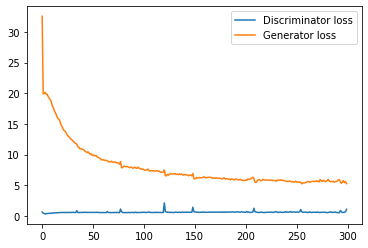

In [6]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_loss_plot, G_loss_plot = [], []


for epoch in tqdm(range(1, NUM_EPOCHS+1)): 

    D_loss_list, G_loss_list = [], []
   
    for batch in train_dataloader:
        D_optimizer.zero_grad()
        input_img = batch['B'].to(device)
        target_img = batch['A'].to(device)
       
        # ground truth labels real and fake
        real_target = Variable(torch.ones(input_img.size(0), 1, 30, 30).to(device))
        fake_target = Variable(torch.zeros(input_img.size(0), 1, 30, 30).to(device))
    
        # generator forward pass
        generated_image = generator(input_img)
        
        # train discriminator with fake/generated images
        disc_inp_fake = torch.cat((input_img, generated_image), 1)
        D_fake = discriminator(disc_inp_fake.detach())
        D_fake_loss   =  discriminator_loss(D_fake, fake_target)
        
        # train discriminator with real images
        disc_inp_real = torch.cat((input_img, target_img), 1)        
        D_real = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(D_real,  real_target)

        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
        
        # compute gradients and run optimizer step
        D_total_loss.backward()
        D_optimizer.step()
        
        
        # Train generator with real labels
        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)                                 
        G_loss_list.append(G_loss)
        
        # compute gradients and run optimizer step
        G_loss.backward()
        G_optimizer.step()
        
    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), NUM_EPOCHS, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)).item())
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)).item())
     
    if epoch % 50 == 0 or epoch == 1:
        torch.save(generator.state_dict(), './generator_epoch_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), './discriminator_epoch_%d.pth' % (epoch))

        for batch in val_dataloader:
            inputs = batch['B'].to(device)
            targets = batch['A'].to(device)
            generated = generator(inputs)
            save_image(flatten([[inputs[i], targets[i], generated[i]] for i in range(3)]), './pix2pix_sample_%d'%epoch + '.png', nrow=3, normalize=True)
            break


plt.plot(D_loss_plot)
plt.plot(G_loss_plot)
plt.legend(['Discriminator loss', 'Generator loss']);